In [ ]:

# Create a 2D Numpy array from list of lists
arr2D = np.array([[11, 12, 13],
[14, 15, 16],
[17, 15, 11],
[12, 14, 15]])

# Find index of minimum value from 2D numpy array
print('List of coordinates of minimum value in Numpy array : ')
# zip the 2 arrays to get the exact coordinates
listOfCordinates = np.where(arr2D == np.amin(arr2D, axis=0))[0]
# travese over the list of cordinates
for cord in listOfCordinates:
    print(cord)

usunac atrybut klasy przed klastrowaniem
efficiency of algo, ile razy przy deterministycznej inicjalizacji trzeba bylo odpalic, itp

In [1]:
import numpy as np

In [2]:
X = np.array([[2.0, 1.0], [1.0, 5.0], [3.0, 2.0]])
cluster = [1, 2]

In [3]:
def center(X, cluster):
    nn, mm = X.shape
    ccc = []
    for jj in range(mm):
        zz = np.array(X[:, jj])
        zc = zz[cluster]
        ccc.append(np.mean(zc, dtype=np.float32))
    
    return np.array(ccc)

print(center(X, cluster))

[2.  3.5]


In [4]:
def dist(X, remains, range_in, a):
    nn, mm = X.shape
    rr = len(remains)
    distan = np.zeros(rr)
    
    for jj in range(mm):
        z = X[:, jj]
        zz = z[remains]
        y = zz - a[jj]
        y = y / range_in[jj]
        yy = np.multiply(y, y)
        #yy = np.reshape(yy,(-1,1))
        distan += yy
        
    return distan

remains = np.array([*range(X.shape[0])])
range_in = []
me = []

for j in range(X.shape[1]):
    range_in.append(max(X[:, j]) - min(X[:, j]))
    me.append(np.mean(X[:, j]))

print(dist(X, remains, range_in, me))

[0.17361111 0.59027778 0.27777778]


In [5]:
def distm(X, remains, range_in, a):
    nn, mm = X.shape
    rr = len(remains)
    z = X[remains, :]
    az = np.tile(a, (rr, 1))
    rz = np.tile(range_in, (rr, 1))
    dz = np.divide(z - az, rz)
    ddz = np.multiply(dz, dz)
    
    if mm > 1:
        di = sum(ddz.T)
    else:
        di = ddz.T
    
    return np.array(di.T)

remains = np.array([*range(X.shape[0])])
range_in = []
me = []

for j in range(X.shape[1]):
    range_in.append(max(X[:, j]) - min(X[:, j]))
    me.append(np.mean(X[:, j]))

print(distm(X, remains, range_in, me))

[0.17361111 0.59027778 0.27777778]


In [6]:
be = np.multiply(-1, me)
be

array([-2.        , -2.66666667])

In [7]:
def separc(X0, remains, range_in, a, b):
    dista = distm(X0, remains, range_in, a)
    distb = distm(X0, remains, range_in, b)
    clus = dista < distb  # has to be np array
    cluster = remains[clus]
    return cluster #??

separc(X, remains, range_in, me, be)

array([0, 1, 2])

In [8]:
def stand(X):
    nn, mm = X.shape
    print('Hit 1 for NO normalization or just "enter"')
    sst = input()
    me = []
    mmax = []
    mmin = []
    range_in = []
    
    for jj in range(mm):
        z = X[:, jj]
        me.append(np.mean(z))
        mmax.append(np.max(z))
        mmin.append(np.min(z))
        
        if sst == "1":
            range_in.append(1)
        else:
            range_in.append(mmax[jj] - mmin[jj])
        
        if range_in[jj] == 0:
            print('Variable number' + str(jj) + '  is constant!')
            range_in[jj] = 1
    
    return me, range_in, mmin, mmax, sst

print(stand(X))

Hit 1 for NO normalization or just "enter"
1
([2.0, 2.6666666666666665], [1, 1], [1.0, 1.0], [3.0, 5.0], '1')


In [9]:
def anpat(X, remains, range_in, centroid, me):
    count = 0
    key = 1
    
    while key == 1:
        cluster = separc(X, remains, range_in, centroid, me)
        if len(cluster) != 0:
            newcenter = center(X, cluster)
        else:
            newcenter = centroid
        if not np.array_equal(centroid, newcenter):
            centroid = newcenter
        else:
            key = 0
    
    return cluster, centroid

print(anpat(X, remains, range_in, [0, 0], me))

(array([], dtype=int32), [0, 0])


In [11]:
def anomalous(X, me, range_in, D):
    nn, mm = X.shape
    remains = np.array([*range(nn)])
    number = -1
    ancl = dict()
    
    while len(remains) > 0:
        distance = dist(X, remains, range_in, me)
        ind = np.argmax(distance)
        index = remains[ind]
        centroid = X[index, :]
        number += 1
        cluster, centroid = anpat(X, remains, range_in, centroid, me)
        #print(cluster, centroid)
        ancl[(number, 1)] = cluster
        censtand = np.divide(centroid - me, range_in)
        dD = censtand * censtand.T * len(cluster) * 100 / D
        ancl[(number, 2)] = censtand
        ancl[(number, 3)] = dD
        remains = np.array(list(set(remains) - set(cluster)))
    
    return ancl

D = X
for i in range(2):
    D[:,i] = (D[:,i] - me[i]) / range_in[i]

print(anomalous(X, me, range_in, D))

{(0, 1): array([0, 1, 2]), (0, 2): array([-1.5       , -0.83333334]), (0, 3): array([[-675.        , -270.27027349],
       [-540.        , -400.00000477],
       [-900.        , -294.11765056]])}


In [153]:
def ceupdate(X, labelc):
    K = max(labelc)
    centres = []
    
    for kk in range(K + 1):
        clk = np.where(labelc == kk)[0]
        
        nc = len(clk)
        elemk = X[clk, :]

        if nc == 0:
            print('At index ' + str(kk) + 'cluster is empty ')
        elif nc == 1:
            centres.append(elemk)
        else:
            centres.append(np.mean(elemk, axis=0))
         
    centres = np.array(centres)
    return centres

In [143]:
def clusterupdate(Y, cent):
    K, m = cent.shape
    N, m = Y.shape # why m again?
    disto = []
    
    for k in range(K):
        cc = cent[k, :]
        Ck = np.tile(cc, (N, 1))
        dif = Y - Ck
        ddif = np.multiply(dif, dif)
        disto.append(np.array(np.sum(ddif, axis=1)).T)
        
    aa = np.amin(disto, axis=0)
    bb = np.where(disto == np.amin(disto, axis=0))[0]
    wc = sum(aa)
    labelc = bb
    return labelc, wc

In [154]:
def k_means(Y, cent, range_in, me):
    N, m = Y.shape
    K, m1 = cent.shape
    flag = 0
    dd = sum(sum(np.multiply(Y, Y)))
    membership = np.zeros((N, 1))
    clusters = dict()
    
    while flag == 0:
        labelc, wc = clusterupdate(Y, cent)
        if np.array_equal(labelc, membership):
            flag = 1
            centre = cent
            w = wc
        else:
            cent = ceupdate(Y, labelc)
            membership = labelc
    
    centrestand = centre
    centrereal = []
    
    for ii in range(K):
        centrereal.append(np.multiply(centre[ii, :], range_in) + me)
    
    wd = w * 100 / dd
    clusters[1] = membership
    clusters[2] = centrestand
    clusters[3] = centrereal
    
    return clusters, wd

In [157]:
def ikmeansb(X, yvar):
    nn, mm = X.shape
    me, range_in, mmin, mmax, sst = stand(X)
    
    sY = (X - me) / range_in
    D = sum(sum(np.multiply(sY, sY)))
    ancl = anomalous(X, me, range_in, D)
    
    print('Input cluster cardinality to discard ')
    threshold = int(input())
    
    b = 3
    aK = int(len(ancl) / b)
    ll = []
    
    for ik in range(aK):
        ll.append(len(ancl[(ik, 1)]))
        
    ll = np.array(ll)
    rl = np.where(ll > threshold)[0]

    cent = []
    
    if len(rl) == 0:
        print('Too great threshold!!!')
    else:
        for ik in range(len(rl)):
            cent.append(ancl[(rl[ik], 2)])
    
    cent = np.array(cent)
    clusters, wd = k_means(sY, cent, range_in, me)
    # no report?
    return clusters, wd

In [160]:
from sklearn.datasets import load_iris

data_in = load_iris()
x_values = data_in.data
clusters, wd = ikmeansb(x_values, [])
print(clusters)

Hit 1 for NO normalization or just "enter"
1
Input cluster cardinality to discard 
10
{1: array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2], dtype=int64), 2: array([[-0.83733333,  0.364     , -2.29466667, -0.95466667],
       [ 0.19833333, -0.25566667,  0.753     ,  0.24633333],
       [ 0.74916667, -0.0715    ,  1.73883333,  0.82383333]]), 3: [array([5.006, 3.418, 1.464, 0.244]), array([6.04166667, 2.79833333, 4.51166667, 1.445     ]), array([6.5925, 2.9825, 5.4975, 2.0225])]}


In [14]:
"""
EXAMPLE
https://pythonhosted.org/scikit-fuzzy/auto_examples/plot_cmeans.html
https://pythonhosted.org/scikit-fuzzy/api/skfuzzy.cluster.html
========================
Fuzzy c-means clustering
========================

Fuzzy logic principles can be used to cluster multidimensional data, assigning
each point a *membership* in each cluster center from 0 to 100 percent. This
can be very powerful compared to traditional hard-thresholded clustering where
every point is assigned a crisp, exact label.

Fuzzy c-means clustering is accomplished via ``skfuzzy.cmeans``, and the
output from this function can be repurposed to classify new data according to
the calculated clusters (also known as *prediction*) via
``skfuzzy.cmeans_predict``

Data generation and setup
-------------------------

In this example we will first undertake necessary imports, then define some
test data to work with.

"""
from __future__ import division, print_function
import numpy as np
import matplotlib.pyplot as plt
import skfuzzy as fuzz

colors = ['b', 'orange', 'g', 'r', 'c', 'm', 'y', 'k', 'Brown', 'ForestGreen']

# Define three cluster centers
centers = [[4, 2],
           [1, 7],
           [5, 6]]

# Define three cluster sigmas in x and y, respectively
sigmas = [[0.8, 0.3],
          [0.3, 0.5],
          [1.1, 0.7]]

# Generate test data
np.random.seed(42)  # Set seed for reproducibility
xpts = np.zeros(1)
ypts = np.zeros(1)
labels = np.zeros(1)
for i, ((xmu, ymu), (xsigma, ysigma)) in enumerate(zip(centers, sigmas)):
    xpts = np.hstack((xpts, np.random.standard_normal(200) * xsigma + xmu))
    ypts = np.hstack((ypts, np.random.standard_normal(200) * ysigma + ymu))
    labels = np.hstack((labels, np.ones(200) * i))

# Visualize the test data
fig0, ax0 = plt.subplots()
for label in range(3):
    ax0.plot(xpts[labels == label], ypts[labels == label], '.',
             color=colors[label])
ax0.set_title('Test data: 200 points x3 clusters.')

"""
.. image:: PLOT2RST.current_figure

Clustering
----------

Above is our test data. We see three distinct blobs. However, what would happen
if we didn't know how many clusters we should expect? Perhaps if the data were
not so clearly clustered?

Let's try clustering our data several times, with between 2 and 9 clusters.

"""
# Set up the loop and plot
fig1, axes1 = plt.subplots(3, 3, figsize=(8, 8))
alldata = np.vstack((xpts, ypts))
fpcs = []

for ncenters, ax in enumerate(axes1.reshape(-1), 2):
    cntr, u, u0, d, jm, p, fpc = fuzz.cluster.cmeans(
        alldata, ncenters, 2, error=0.005, maxiter=1000, init=None)

    # Store fpc values for later
    fpcs.append(fpc)

    # Plot assigned clusters, for each data point in training set
    cluster_membership = np.argmax(u, axis=0)
    for j in range(ncenters):
        ax.plot(xpts[cluster_membership == j],
                ypts[cluster_membership == j], '.', color=colors[j])

    # Mark the center of each fuzzy cluster
    for pt in cntr:
        ax.plot(pt[0], pt[1], 'rs')

    ax.set_title('Centers = {0}; FPC = {1:.2f}'.format(ncenters, fpc))
    ax.axis('off')

fig1.tight_layout()

"""
.. image:: PLOT2RST.current_figure

The fuzzy partition coefficient (FPC)
-------------------------------------

The FPC is defined on the range from 0 to 1, with 1 being best. It is a metric
which tells us how cleanly our data is described by a certain model. Next we
will cluster our set of data - which we know has three clusters - several
times, with between 2 and 9 clusters. We will then show the results of the
clustering, and plot the fuzzy partition coefficient. When the FPC is
maximized, our data is described best.

"""

fig2, ax2 = plt.subplots()
ax2.plot(np.r_[2:11], fpcs)
ax2.set_xlabel("Number of centers")
ax2.set_ylabel("Fuzzy partition coefficient")

"""
.. image:: PLOT2RST.current_figure

As we can see, the ideal number of centers is 3. This isn't news for our
contrived example, but having the FPC available can be very useful when the
structure of your data is unclear.

Note that we started with *two* centers, not one; clustering a dataset with
only one cluster center is the trivial solution and will by definition return
FPC == 1.


====================
Classifying New Data
====================

Now that we can cluster data, the next step is often fitting new points into
an existing model. This is known as prediction. It requires both an existing
model and new data to be classified.

Building the model
------------------

We know our best model has three cluster centers. We'll rebuild a 3-cluster
model for use in prediction, generate new uniform data, and predict which
cluster to which each new data point belongs.

"""
# Regenerate fuzzy model with 3 cluster centers - note that center ordering
# is random in this clustering algorithm, so the centers may change places
cntr, u_orig, _, _, _, _, _ = fuzz.cluster.cmeans(
    alldata, 3, 2, error=0.005, maxiter=1000)

# Show 3-cluster model
fig2, ax2 = plt.subplots()
ax2.set_title('Trained model')
for j in range(3):
    ax2.plot(alldata[0, u_orig.argmax(axis=0) == j],
             alldata[1, u_orig.argmax(axis=0) == j], 'o',
             label='series ' + str(j))
ax2.legend()

"""
.. image:: PLOT2RST.current_figure

Prediction
----------

Finally, we generate uniformly sampled data over this field and classify it
via ``cmeans_predict``, incorporating it into the pre-existing model.

"""

# Generate uniformly sampled data spread across the range [0, 10] in x and y
newdata = np.random.uniform(0, 1, (1100, 2)) * 10

# Predict new cluster membership with `cmeans_predict` as well as
# `cntr` from the 3-cluster model
u, u0, d, jm, p, fpc = fuzz.cluster.cmeans_predict(
    newdata.T, cntr, 2, error=0.005, maxiter=1000)

# Plot the classified uniform data. Note for visualization the maximum
# membership value has been taken at each point (i.e. these are hardened,
# not fuzzy results visualized) but the full fuzzy result is the output
# from cmeans_predict.
cluster_membership = np.argmax(u, axis=0)  # Hardening for visualization

fig3, ax3 = plt.subplots()
ax3.set_title('Random points classifed according to known centers')
for j in range(3):
    ax3.plot(newdata[cluster_membership == j, 0],
             newdata[cluster_membership == j, 1], 'o',
             label='series ' + str(j))
ax3.legend()

plt.show()

"""
.. image:: PLOT2RST.current_figure

"""


<Figure size 640x480 with 1 Axes>

<Figure size 800x800 with 9 Axes>

<Figure size 640x480 with 1 Axes>

<Figure size 640x480 with 1 Axes>

<Figure size 640x480 with 1 Axes>

'\n.. image:: PLOT2RST.current_figure\n\n'

In [27]:
from numpy import genfromtxt
data = genfromtxt('tripadvisor_review.csv', delimiter=',')
data = data[1:, 1:]

x = data[:,5] # Resorts
y = data[:,4] # Museums

alldata = np.vstack((x, y))    # how to visualize data with more than 2/3 features?

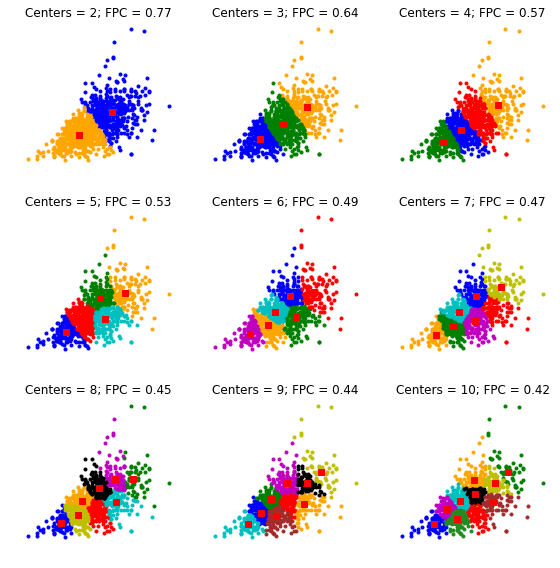

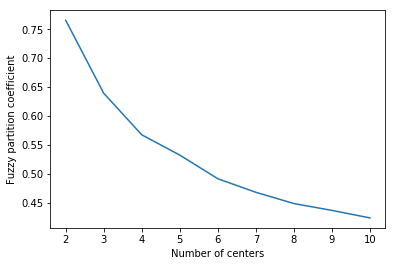

In [28]:
fig1, axes1 = plt.subplots(3, 3, figsize=(8, 8))
fpcs = []

for ncenters, ax in enumerate(axes1.reshape(-1), 2):
    cntr, u, u0, d, jm, p, fpc = fuzz.cluster.cmeans(
        alldata, ncenters, 2, error=0.005, maxiter=1000, init=None)

    # Store fpc values for later
    fpcs.append(fpc)

    # Plot assigned clusters, for each data point in training set
    cluster_membership = np.argmax(u, axis=0)
    for j in range(ncenters):
        ax.plot(x[cluster_membership == j],
                y[cluster_membership == j], '.', color=colors[j])

    # Mark the center of each fuzzy cluster
    for pt in cntr:
        ax.plot(pt[0], pt[1], 'rs')

    ax.set_title('Centers = {0}; FPC = {1:.2f}'.format(ncenters, fpc))
    ax.axis('off')

fig1.tight_layout()

fig2, ax2 = plt.subplots()
ax2.plot(np.r_[2:11], fpcs)
ax2.set_xlabel("Number of centers")
ax2.set_ylabel("Fuzzy partition coefficient");

// the less clusters the better xD